In [1]:
import boolean2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [2]:
def plot_state_succession(states,state_labels=None,title=None, nodes=None, fontsizex=10):

    '''
    Creates a plot of the trajectory performed by a BooleanNet model.
    
    Inputs:
    states - container of boolean2 State objects or of dictionaries equivalent to those.
    state_labels (optional) - container of strings corresponding to every state. They will be the labels on the Y axis. Default: range(len(states))
    title (optional) - the title of the plot
    nodes (optional) - the set of nodes to be whose trajectory should be plotted. The set can be a subset or identical set to the nodes in the states. If list the order of the list will be respected on the plot.
    fontsizex (optional) - the fontsize of the X axis labels (the node names). Default: 10
    
    '''
    from matplotlib import pyplot as plt
    import matplotlib
    if nodes==None:
        nodes=states[0].keys()
    state_transition=[]
    for s in states:
        state_transition.append([s[k] for k in nodes])
    cmap = matplotlib.colors.ListedColormap(['blue', 'orange'])
    steps=len(state_transition)
    plt.figure(figsize=(len(nodes),steps))
    plt.imshow(state_transition, interpolation='none',cmap=cmap)
    ax = plt.gca()
    plt.xticks(range(len(nodes)),nodes, fontsize=fontsizex)   
    if state_labels==None:
        plt.yticks(range(steps),fontsize=12)
    else:
        plt.yticks(range(steps),state_labels,fontsize=12)
    if title!=None:
        plt.title(title)
    ax.set_yticks(np.arange(-.5, steps,1),minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=2)
    plt.show()

import random
def general_async_pick( lines ):
    data = [ random.choice( lines )]
    print(data)
    return data   

class TransGraph(object):
    """
    Represents a transition graph
    """
    import networkx as nx
    def __init__(self, logfile, verbose=False):
        self.graph = nx.MultiDiGraph(  )         
        self.fp = open( logfile, 'wt')
        self.verbose = verbose
        self.seen = set()
        self.store = dict()
        self.colors = dict()

    def add(self, states, times=None):
        "Adds states to the transition"
    
        # generating the fingerprints and sto
        times = times or range(len(states))
        fprints = []
        for state in states:
            if self.verbose:
                fp = state.bin()
            else:
                fp = state.fp()
            fprints.append( fp )
            self.store[fp] = state

        self.fp.write( '*** transitions from %s ***\n' % fprints[0] )

        for head, tail, tstamp in zip(fprints, fprints[1:], times ):
            pair = (head, tail)
            self.fp.write('T=%s: %s->%s\n' %  (tstamp, head, tail) ) 
            if pair not in self.seen:
                self.graph.add_edge(head, tail)
                self.seen.add(pair)
        
    def save(self, fname, colormap={}):
        "Saves the graph as gml"
        write_gml(graph=self.graph, fname=fname, colormap=colormap)
    
        self.fp.write( '*** node values ***\n' )

        # writes the mapping
        first = self.store.values()[0]
        header = [ 'state' ] + first.keys()
        self.fp.write( util.join(header) )
        
        for fprint, state in sorted( self.store.items() ):
            line = [ fprint ]  + map(int, state.values() )
            self.fp.write( util.join(line) )
            
def read_rules_text(model_name):
    """
    A simple file reading function, that reads the BooleanNet rules text files and returns them as a string
    
    Input: 
    model_name - str, containing the name of the model, assuming the convention, that the model files are name are named "model_name".txt
    
    Returns:
    rules - str, the boolean rules contained in the file
    """
    rules_file='%s.txt'%model_name
    with open(rules_file,'r') as f:
        rules=f.read()
    rules=rules.replace('#BOOLEAN RULES','') #in some cases this line is in the file, but we don't need it
    return rules

def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

def default_shuffler( lines ):
    "Default shuffler"
    temp = lines[:]
    random.shuffle( lines )
    return temp

In [3]:
list=[]
while True:
    try:
        #insert name and extension file excel with binary values
        Table="SUPPLEMENTARY_TABLE_6.xlsx"
                
        #get a dataframe from the excel sheet
        df=pd.read_excel(Table)
        
        try:
            #indicate the cell in which to look for attractors
            cellname="BC04_54"
            
            #tranforms the values of the columns to be processed from "1" and"0"
            #to "True" and "False"
            df['TF']=df[cellname].apply(lambda x : 'True' if x == 1 else 'False')
        except IOError:
            print("The cell name is incorrect")
            
    except IOError:
         print("The file name is incorrect")
         continue
    break

#create a new dataframe with only two columns,the name of the genes and 
#their Boolean value "True" or "False"
mod_df=df[['gene_name','TF']]

#create a list with values in columns of the dataframe "mod_df"
#interspersed with the symbol "="
for i in mod_df.index:
    list.append(mod_df["gene_name"][i] + " = " + mod_df["TF"][i]+"\n")

#tranformation of the list format into a string required for processing
model_definition1=''.join(list)


In [4]:
model_name='breast-cancer'
rules=read_rules_text(model_name)

In [5]:
model_definition = model_definition1 + rules

In [6]:
sync_model = boolean2.Model(model_definition, mode='sync')
sync_model.initialize()

In [7]:
steps = 50
sync_model.iterate(steps)

In [8]:
_,cycle_length=sync_model.detect_cycles() #.detect_cycles returns the starting point and the length of a cycle
print(cycle_length)
cycle_states = sync_model.states[-cycle_length:]

11


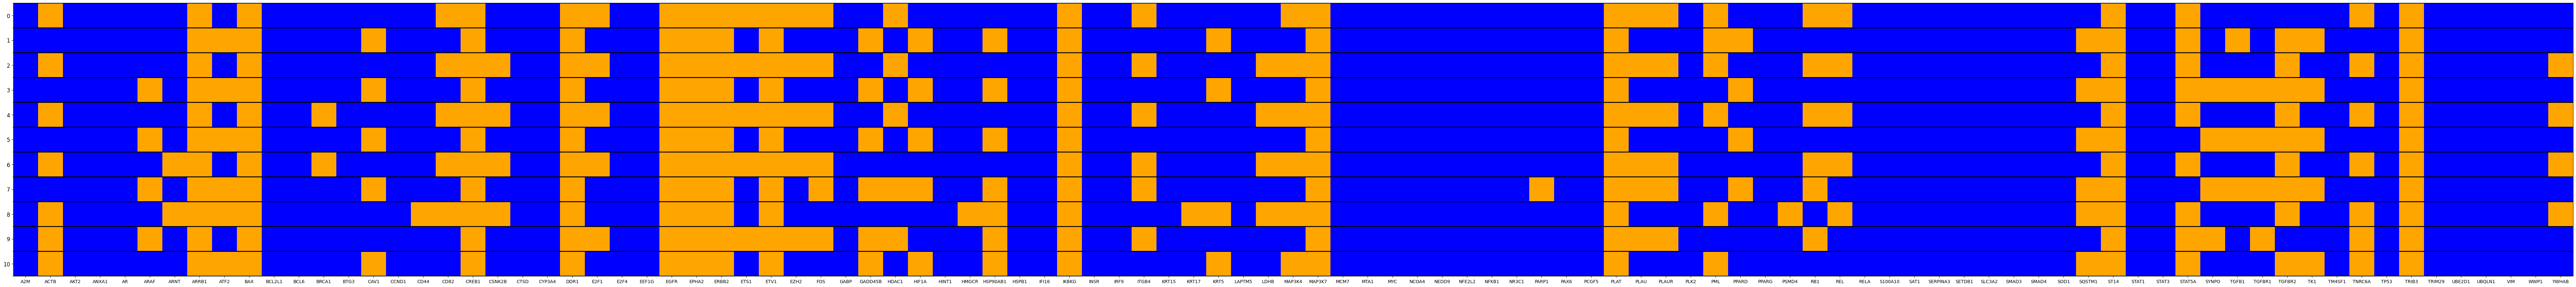

In [9]:
plot_state_succession(cycle_states) #blue: false, orange: true

In [12]:
import networkx as nx
from itertools import combinations, product
from collections import Counter

nr_of_steps = 10000

async_model = boolean2.Model(model_definition, mode='async')

start_state=cycle_states[0]
async_model.initialize()
async_model.iterate(nr_of_steps,shuffler=general_async_pick)

TG=TransGraph(logfile='states.txt')
TG.add(async_model.states)
G=TG.graph
print("Number of unique states visited:",G.number_of_nodes())
print("Number of unique transitions:",G.number_of_edges())

['STAT1 * = ( CREB1 or BRCA1 ) and not ( ARRB1 or PML or HDAC1 )']
['BAX * = not BCL2L1']
['IFI16 * = TP53']
['HIF1A * = ( CREB1 or NFKB1 or STAT3 or BRCA1 or REL or HSP90AB1 or ARRB1 or MTA1 or ARNT or RELA or ATF2 or E2F1 or HIF1A or PARP1 or HDAC1 or SAT1 ) and not ( TP53 or PSMD4 or MCM7 or SQSTM1 or STAT1 )']
['SYNPO * = YWHAB']
['KRT5 * = FOS and not BRCA1']
['EPHA2 * = ( TP53 or AKT2 or ETS1 or CREB1 ) and not ( MTA1 or RELA )']
['PML * = ( TP53 or IRF9 or STAT5A or STAT1 or RB1 ) and not CSNK2B']
['STAT3 * = ( CREB1 or STAT3 or FOS or ATF2 or EZH2 or MTA1 or HIF1A or NFKB1 or SETDB1 or CD44 or RELA ) and not ( HDAC1 or RB1 or PML or CAV1 or CCND1 )']
['IKBKG * = HSP90AB1 or ANXA1 or MAP3K7 or SQSTM1']
['SOD1 * = ( NFE2L2 or RELA ) and not ( HDAC1 or CAV1 or PSMD4 )']
['EPHA2 * = ( TP53 or AKT2 or ETS1 or CREB1 ) and not ( MTA1 or RELA )']
['LDHB * = STAT3 or PPARD']
['CCND1 * = ( CREB1 or NFKB1 or E2F1 or FOS or ATF2 or STAT1 or PARP1 or REL or EZH2 or ETS1 or STAT5A or MTA1 or

In [ ]:
#ikan

## Calculating some of the metrics discussed above
fp_state_dict=dict(zip(async_model.fp(),async_model.states))
overlap_to_sync_cycle={}
closest_sync_state={}
for n in G.nodes:
    async_state=fp_state_dict[n]
    overlaps=[]
    for j in range(len(cycle_states)):
        
        #async_state=dict(zip(model_async.nodes,top_PR_states[i]))
        sync_state=cycle_states[j]
        overlap=0
        for s in async_state.keys():
            if async_state[s] == sync_state[s]:
                overlap+=1.
        overlap/=len(async_state.keys())
        overlaps.append(overlap)
        
    overlap_to_sync_cycle[n]=max(overlaps)
    closest_sync_state[n]=overlaps.index(max(overlaps))

fp_states=async_model.fp()
state_occurances=Counter(fp_states)
edge_occurances=Counter([(fp_states[i-1], fp_states[i]) for i in range(len(fp_states))])

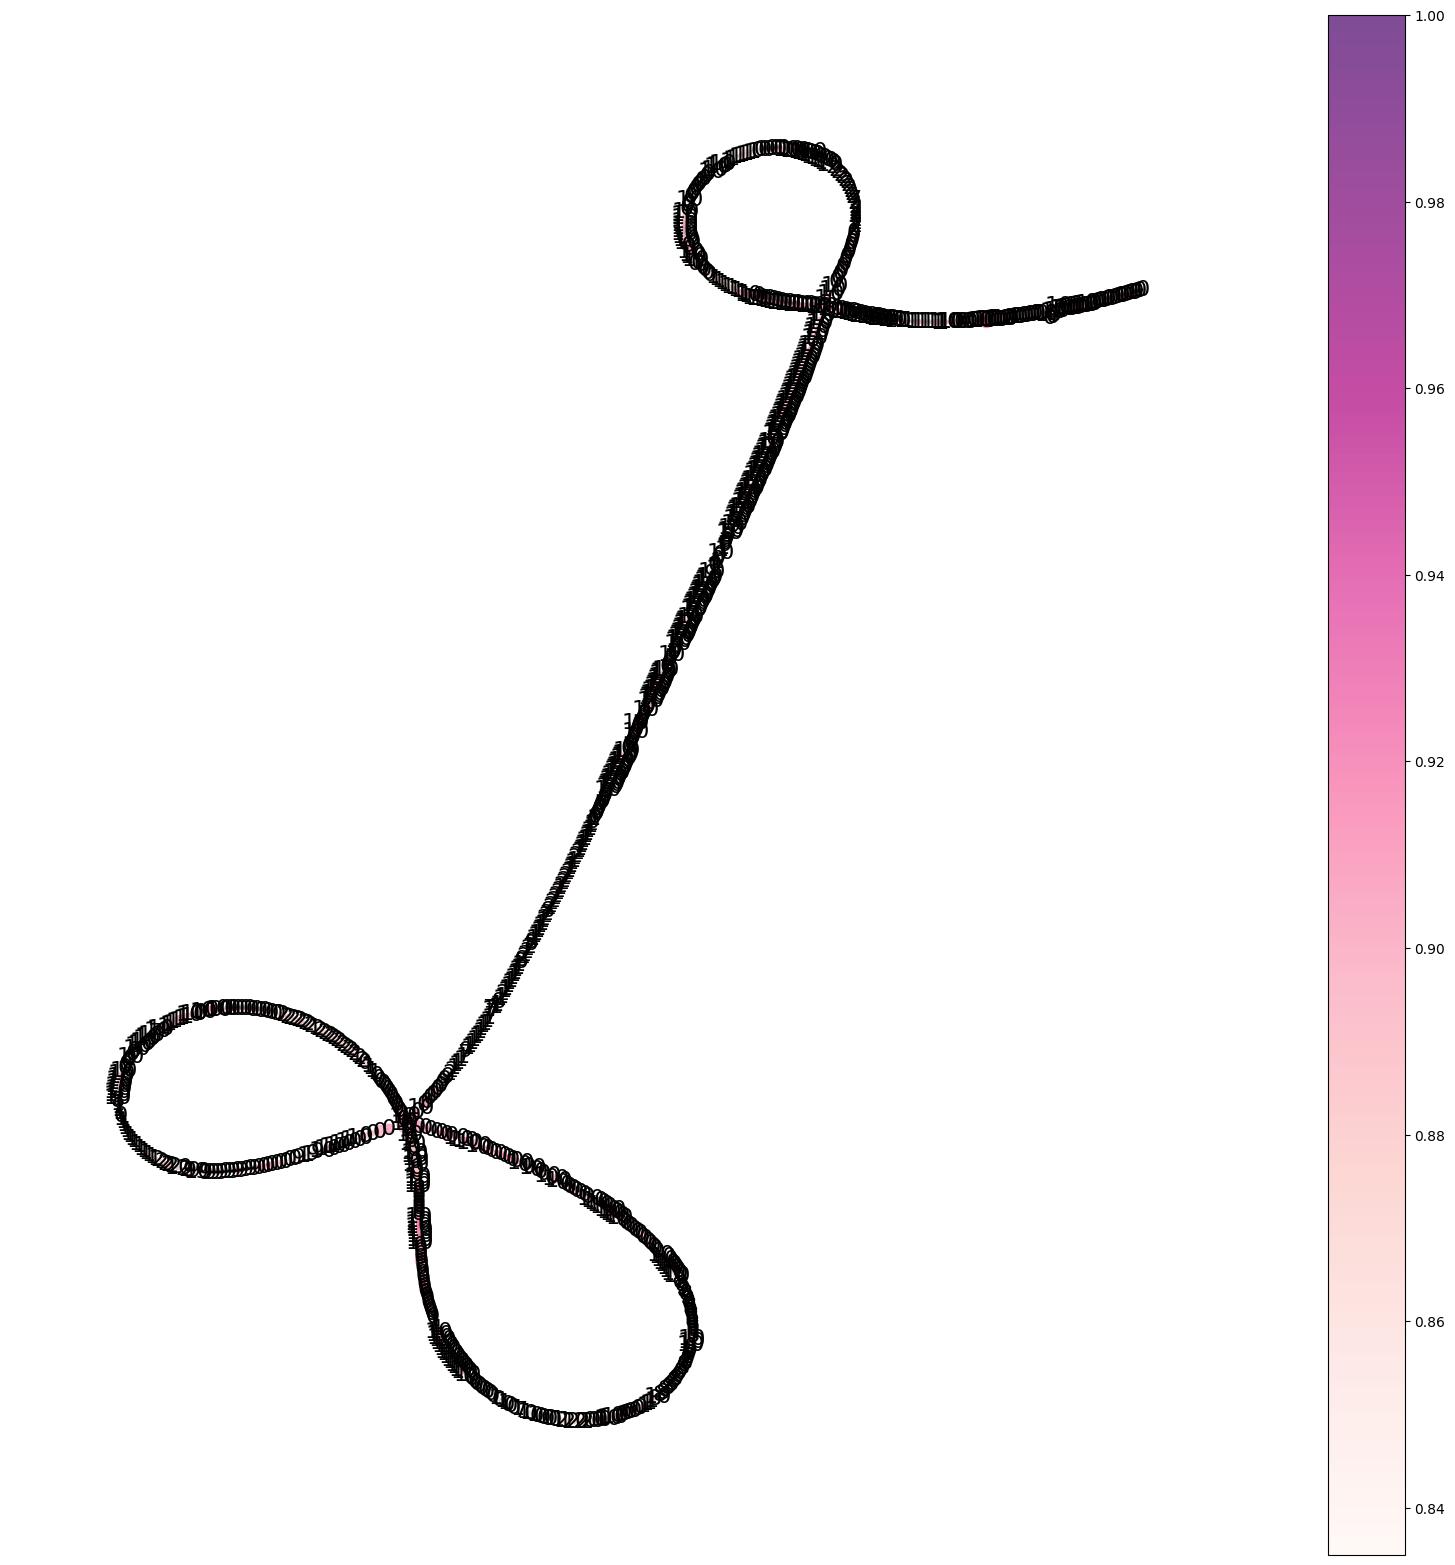

In [ ]:
# # drawing nodes and edges separately so we can capture collection for colobar
# # G.remove_edges_from(nx.selfloop_edges(G))

# plt.figure(figsize=(20,20))
# pos = nx.kamada_kawai_layout(G)
# ec = nx.draw_networkx_edges(G, pos, alpha=0.2,width=[float(edge_occurances[i])*0.1 for i in G.edges()])
# lc = nx.draw_networkx_labels(G,pos,{i:closest_sync_state[i] for i in G.nodes()}, font_size=16)
# nc = nx.draw_networkx_nodes(G, pos, node_color=[overlap_to_sync_cycle[i] for i in G.nodes()], node_size=[float(state_occurances[j]) for j in G.nodes()], cmap=plt.cm.RdPu, alpha=0.7)
# plt.colorbar(nc)
# plt.axis('off')
# plt.show()

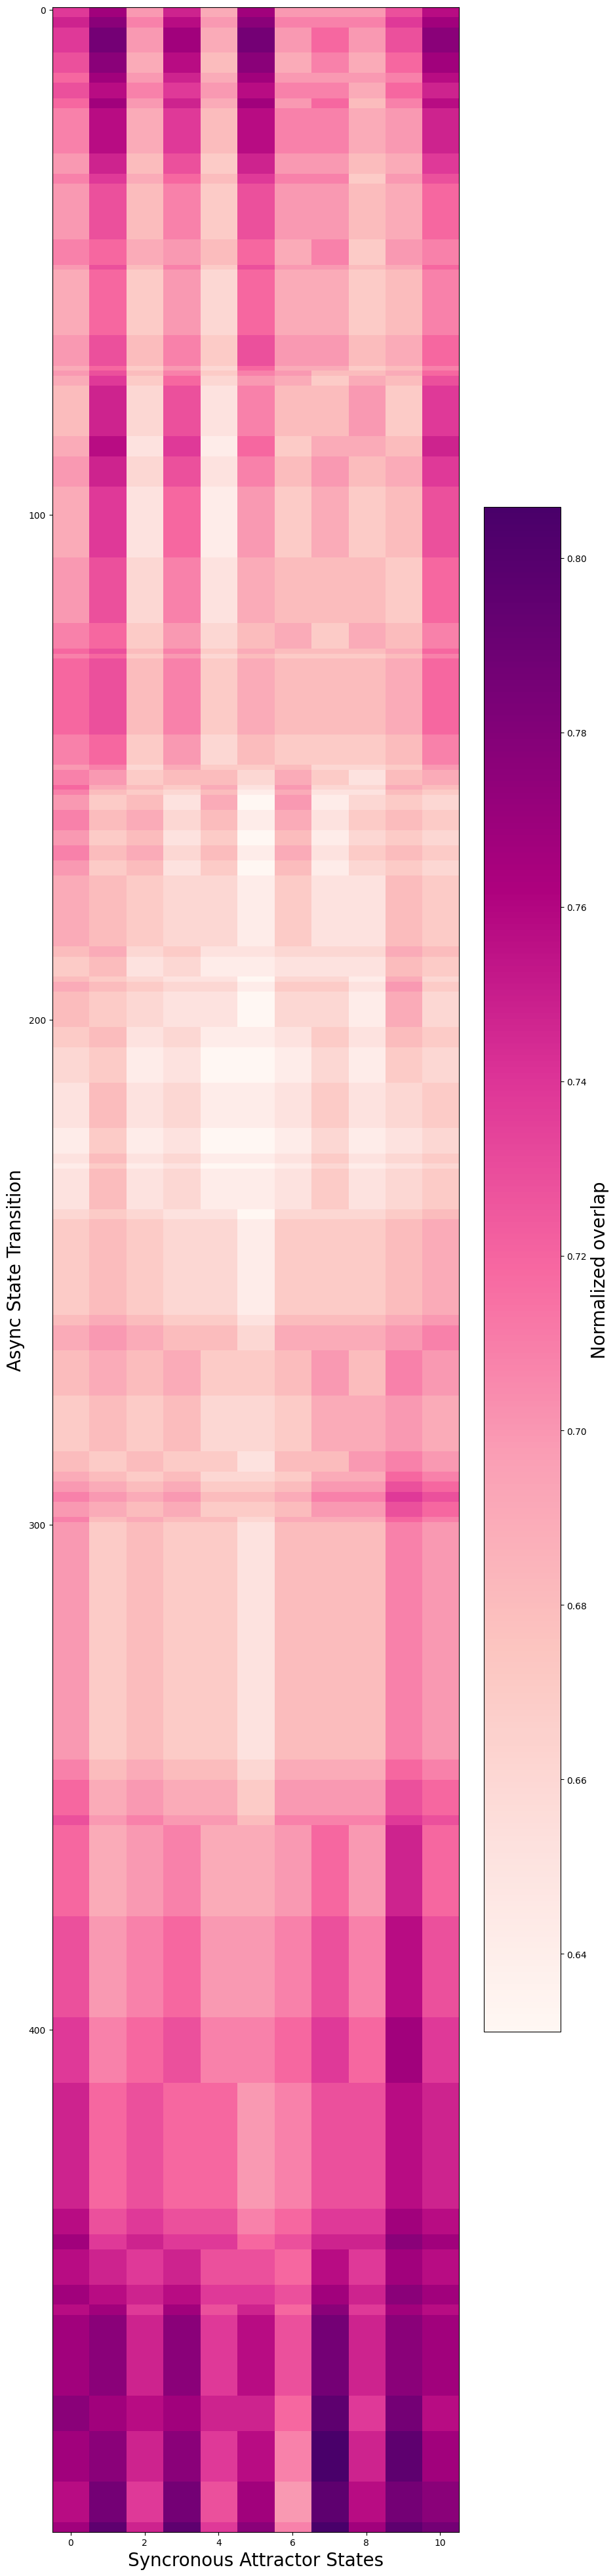

In [13]:
selected_states=async_model.states[:500]
hamming_dist_top_async_sync=np.zeros((len(selected_states),len(cycle_states)))
for i in range(len(selected_states)):
    for j in range(len(cycle_states)):
        
        #async_state=dict(zip(model_async.nodes,top_PR_states[i]))
        async_state=selected_states[i]
        sync_state=cycle_states[j]
        
        for s in async_state.keys():
            if async_state[s] == sync_state[s]:
                hamming_dist_top_async_sync[i,j]+=1.
                
hamming_dist_top_async_sync/=len(async_model.nodes)
plt.figure(figsize=(10,50))
plt.imshow(hamming_dist_top_async_sync, cmap=plt.cm.RdPu, aspect='auto')
plt.xlabel('Syncronous Attractor States',fontsize=20)
plt.ylabel('Async State Transition',fontsize=20)
clb=plt.colorbar()
clb.set_label('Normalized overlap',fontsize=20)

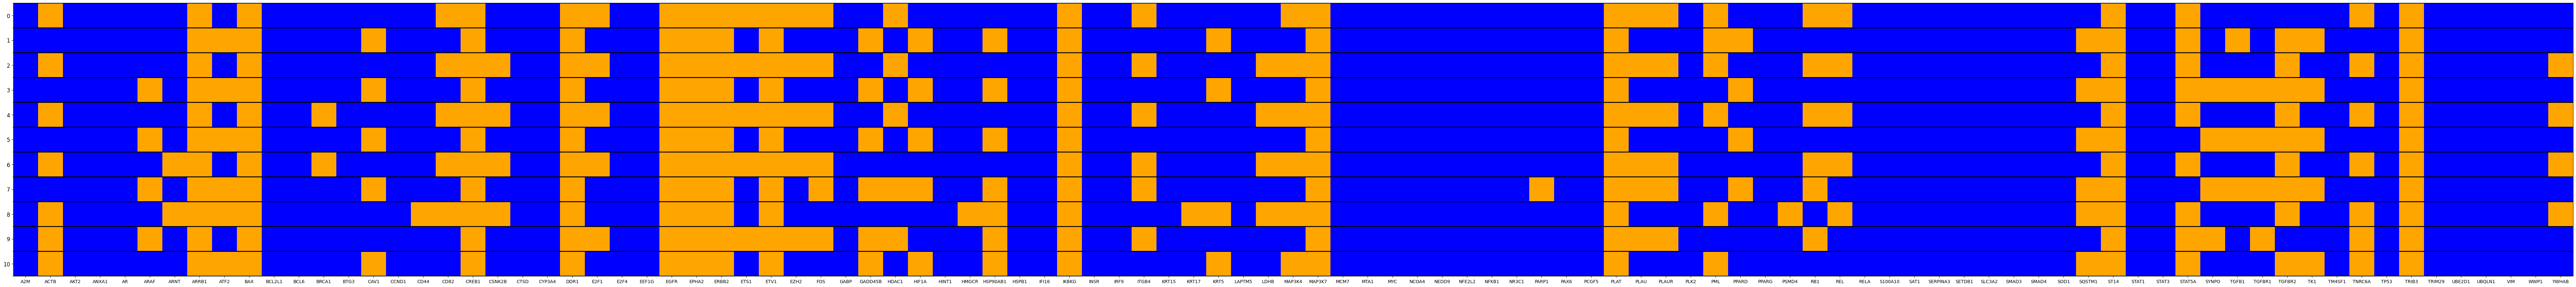

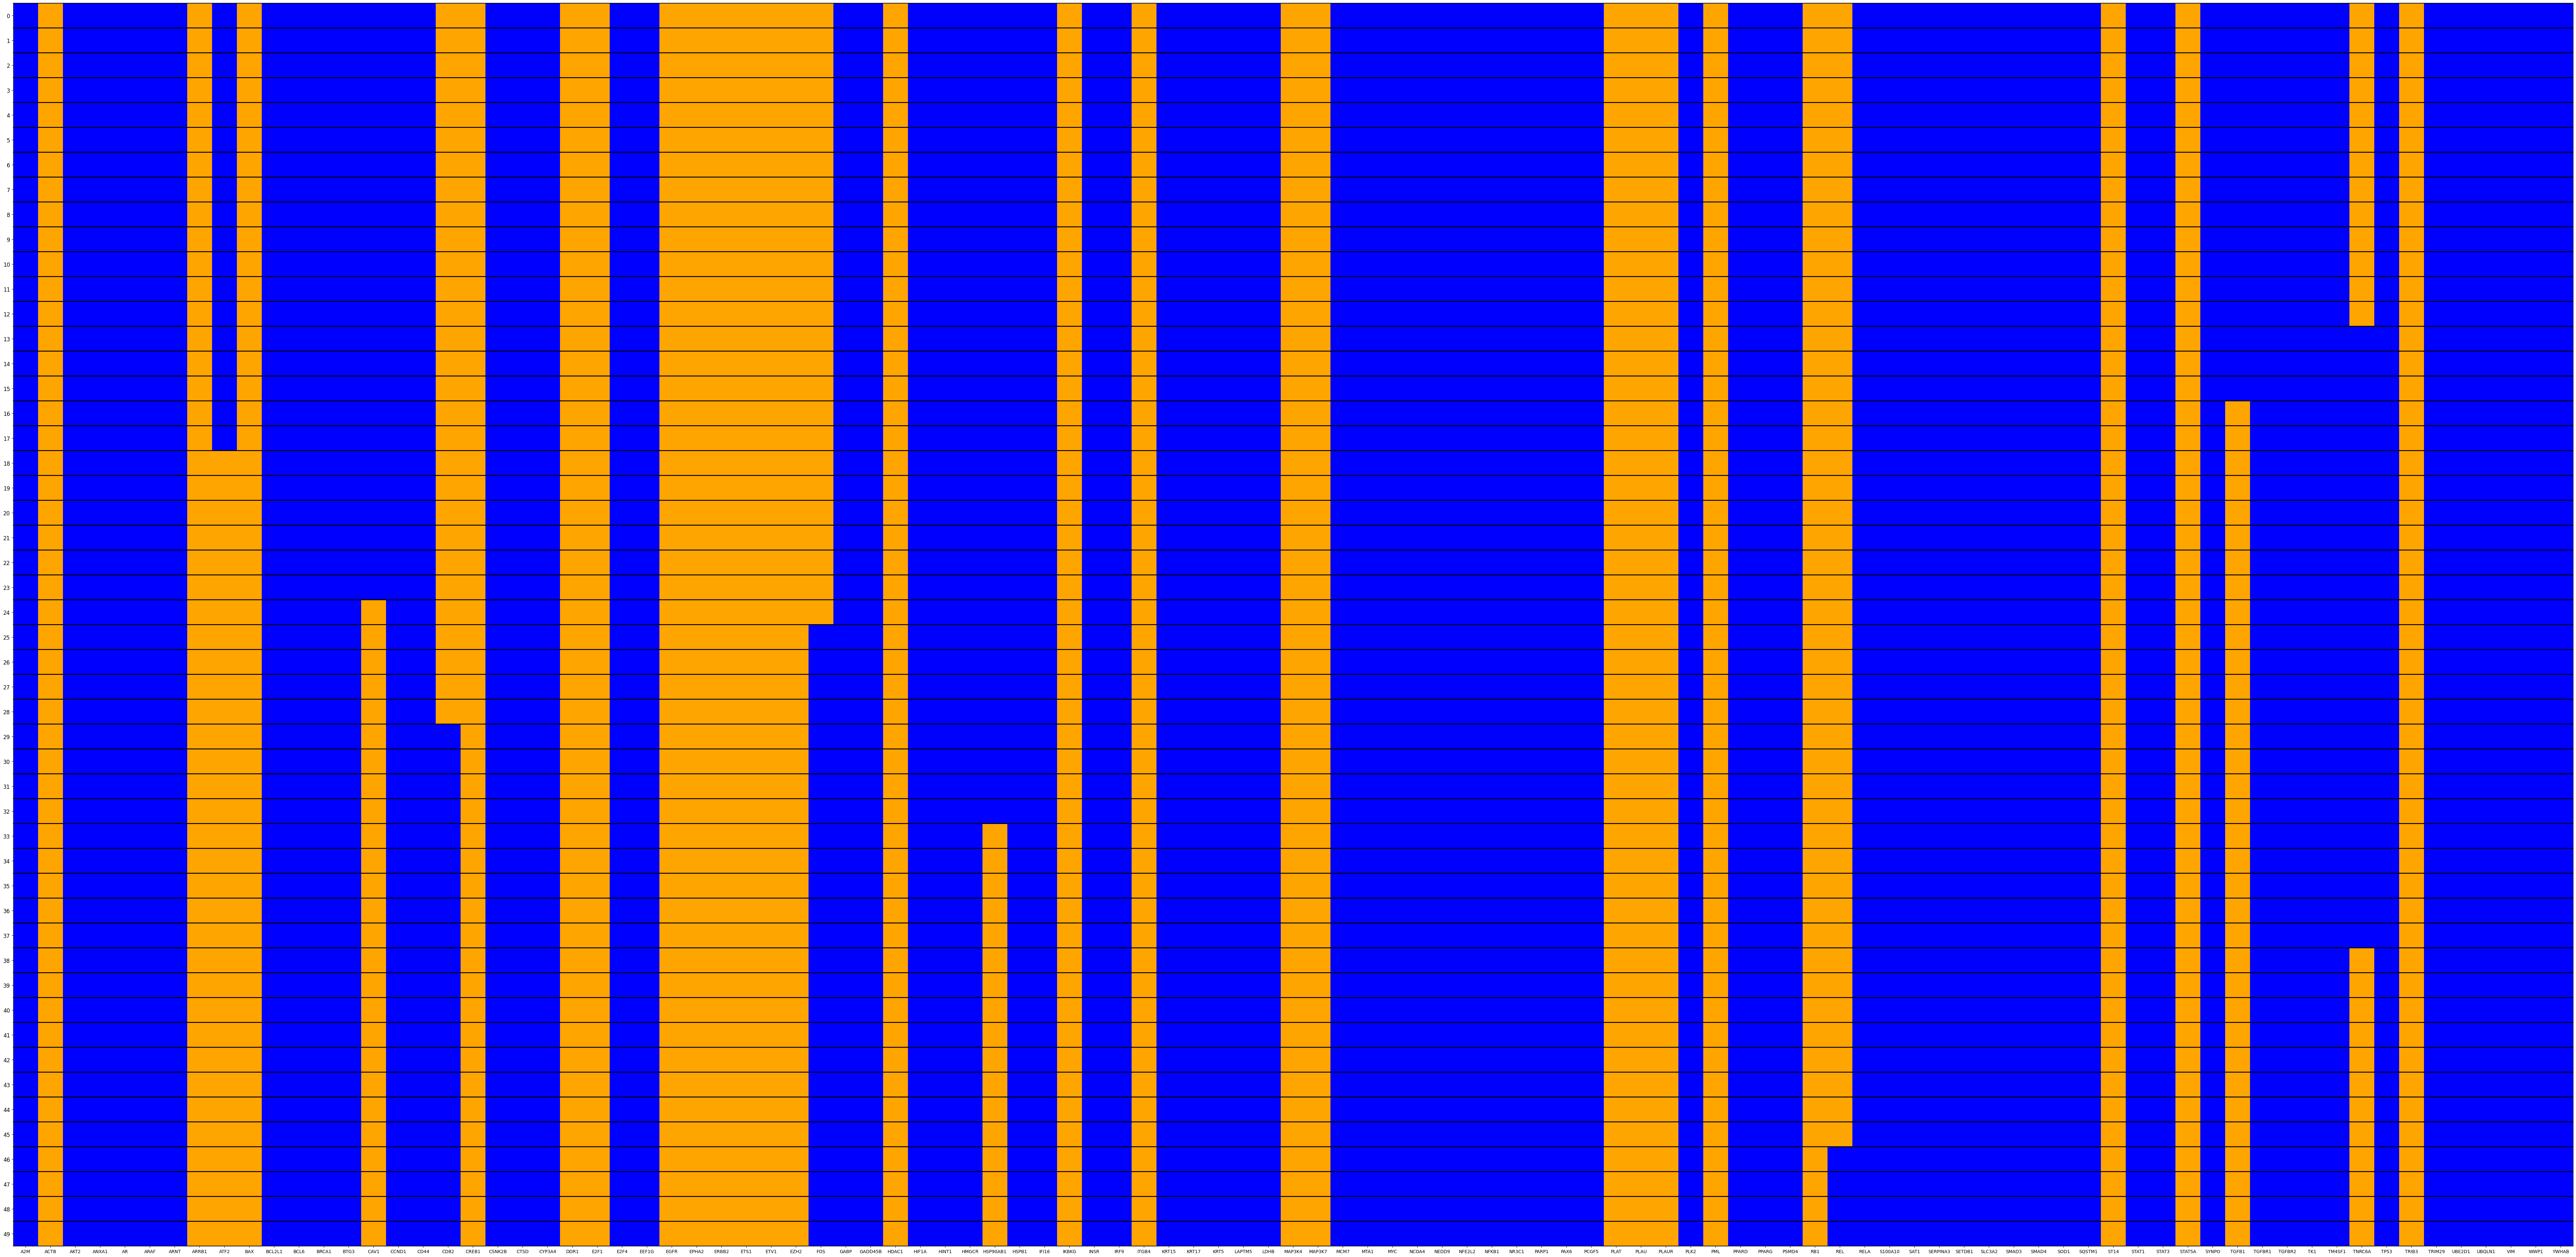

In [11]:
selected_states=async_model.states[:50]
plot_state_succession(cycle_states) #blue: false, orange: true
plot_state_succession(selected_states) #blue: false, orange: true